# Imports

In [898]:
import pandas as pd
import numpy as np

import datetime as dt
import reverse_geocoder as rg
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

from sklearn.cluster import KMeans, DBSCAN, MeanShift
import scipy.cluster.hierarchy as sch
from minisom import MiniSom
from sklearn.decomposition import PCA
from umap import UMAP

from collections import Counter, defaultdict

import warnings
warnings.filterwarnings("ignore")  # Suppress all warnings

from my_functions import *  #feature_engineering_info, feature_engineering_basket, all_purchased_items
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [899]:
basket_df = pd.read_csv('customer_basket.csv')
info_df = pd.read_csv('customer_info.csv')

# Exploratory Data Analysis

In [900]:
basket_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   invoice_id     100000 non-null  int64 
 1   list_of_goods  100000 non-null  object
 2   customer_id    100000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 2.3+ MB


In [901]:
basket_df.describe(include='all').T

count unique      top freq           mean             std  \
invoice_id     100000.0    NaN      NaN  NaN  6124713.66375  3533207.950417   
list_of_goods    100000  98742  ['oil']   33            NaN             NaN   
customer_id    100000.0    NaN      NaN  NaN    16945.56902     9837.987201   

                   min        25%        50%         75%         max  
invoice_id     20054.0  3066431.5  6118618.0  9195346.75  12242220.0  
list_of_goods      NaN        NaN        NaN         NaN         NaN  
customer_id        1.0     8425.0    16917.0     25536.0     34060.0

In [902]:
basket_df.head()

invoice_id                                      list_of_goods  customer_id
0     5062209  ['megaman zero 3', 'energy bar', 'pokemon viol...         4925
1     4272512  ['black beer', 'bramble', 'laptop', 'pokemon v...        19046
2     7121052  ['soup', 'shallot', 'cake', 'fresh bread', 'cr...        10318
3     5847748  ['soup', 'cooking oil', 'cereals', 'oil', 'dog...        27283
4     6336114  ['eggplant', 'mint green tea', 'oil', 'bacon',...        16072

In [903]:
info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34060 entries, 0 to 34059
Data columns (total 26 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Unnamed: 0                               34060 non-null  int64  
 1   customer_id                              34060 non-null  int64  
 2   customer_name                            34060 non-null  object 
 3   customer_gender                          34060 non-null  object 
 4   customer_birthdate                       33719 non-null  object 
 5   kids_home                                33311 non-null  float64
 6   teens_home                               33277 non-null  float64
 7   number_complaints                        33038 non-null  float64
 8   distinct_stores_visited                  33379 non-null  float64
 9   lifetime_spend_groceries                 34060 non-null  float64
 10  lifetime_spend_electronics               34060

In [904]:
info_df.describe(include='all').T

count unique                  top  \
Unnamed: 0                               34060.0    NaN                  NaN   
customer_id                              34060.0    NaN                  NaN   
customer_name                              34060  33579         Robert Brown   
customer_gender                            34060      2                 male   
customer_birthdate                         33719  33710  12/23/1956 11:57 PM   
kids_home                                33311.0    NaN                  NaN   
teens_home                               33277.0    NaN                  NaN   
number_complaints                        33038.0    NaN                  NaN   
distinct_stores_visited                  33379.0    NaN                  NaN   
lifetime_spend_groceries                 34060.0    NaN                  NaN   
lifetime_spend_electronics               34060.0    NaN                  NaN   
typical_hour                             32698.0    NaN                  NaN   
lifetime_spend_vegetables                33038.0    NaN                  NaN   
lifetime_spend_nonalcohol_drinks         34060.0    NaN                  NaN   
lifetime_spend_alcohol_drinks            33379.0    NaN                  NaN   
lifetime_spend_meat                      34060.0    NaN                  NaN   
lifetime_spend_fish                      32357.0    NaN                  NaN   
lifetime_spend_hygiene                   34060.0    NaN                  NaN   
lifetime_spend_videogames                34060.0    NaN                  NaN   
lifetime_spend_petfood                   34060.0    NaN                  NaN   
lifetime_total_distinct_products         34060.0    NaN                  NaN   
percentage_of_products_bought_promotion  34060.0    NaN                  NaN   
year_first_transaction                   34060.0    NaN                  NaN   
loyalty_card_number                      23152.0    NaN                  NaN   
latitude                                 34060.0    NaN                  NaN   
longitude                                34060.0    NaN                  NaN   

                                          freq           mean           std  \
Unnamed: 0                                 NaN        17029.5   9832.419421   
customer_id                                NaN   20010.854433  11557.889072   
customer_name                                6            NaN           NaN   
customer_gender                          17133            NaN           NaN   
customer_birthdate                           2            NaN           NaN   
kids_home                                  NaN       1.170244      1.307319   
teens_home                                 NaN       0.936292      0.759579   
number_complaints                          NaN       0.832042      0.771205   
distinct_stores_visited                    NaN       2.914078      1.549081   
lifetime_spend_groceries                   NaN   22818.404698  20098.763199   
lifetime_spend_electronics                 NaN    3816.022343    3858.35264   
typical_hour                               NaN      13.200746      4.681384   
lifetime_spend_vegetables                  NaN     738.642079    679.599323   
lifetime_spend_nonalcohol_drinks           NaN     478.382854    282.132536   
lifetime_spend_alcohol_drinks              NaN     838.482998    596.518224   
lifetime_spend_meat                        NaN     916.211274    534.330738   
lifetime_spend_fish                        NaN     828.842662      655.8033   
lifetime_spend_hygiene                     NaN     711.297534    481.230522   
lifetime_spend_videogames                  NaN     399.434968     320.22165   
lifetime_spend_petfood                     NaN     317.755843    150.513835   
lifetime_total_distinct_products           NaN     156.691339    118.969652   
percentage_of_products_bought_promotion    NaN       0.337093      0.322766   
year_first_transaction                     NaN    2014.593218    

In [905]:
# Percentage of missing values in each column
for col in info_df.columns:
    pct_missing = np.mean(info_df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

Unnamed: 0 - 0%
customer_id - 0%
customer_name - 0%
customer_gender - 0%
customer_birthdate - 1%
kids_home - 2%
teens_home - 2%
number_complaints - 3%
distinct_stores_visited - 2%
lifetime_spend_groceries - 0%
lifetime_spend_electronics - 0%
typical_hour - 4%
lifetime_spend_vegetables - 3%
lifetime_spend_nonalcohol_drinks - 0%
lifetime_spend_alcohol_drinks - 2%
lifetime_spend_meat - 0%
lifetime_spend_fish - 5%
lifetime_spend_hygiene - 0%
lifetime_spend_videogames - 0%
lifetime_spend_petfood - 0%
lifetime_total_distinct_products - 0%
percentage_of_products_bought_promotion - 0%
year_first_transaction - 0%
loyalty_card_number - 32%
latitude - 0%
longitude - 0%


In [906]:
# Percentage of missing values in each column
for col in basket_df.columns:
    pct_missing = np.mean(basket_df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

invoice_id - 0%
list_of_goods - 0%
customer_id - 0%


# Preprocessing

In [907]:
# Get all new features for info_df
info_df = feature_engineering_info(info_df)

In [908]:
# Get all new features for basket_df
basket_df = feature_engineering_basket(basket_df)

In [909]:
# Get a full list of all items purchased for each customer (with repetitions)
all_items = all_purchased_items(basket_df)

In [910]:
all_items.head()

customer_id                                all_purchased_items
0            1  [pickles, protein bar, mashed potato, beer, tu...
1            2  [shampoo, tooth brush, portal, vegetables mix,...
2            4  [shallot, mashed potato, olive oil, asparagus,...
3            5  [candy bars, zucchini, mint green tea, strong ...
4            6  [candy bars, gadget for tiktok streaming, port...

# Visualization

## General data visualization

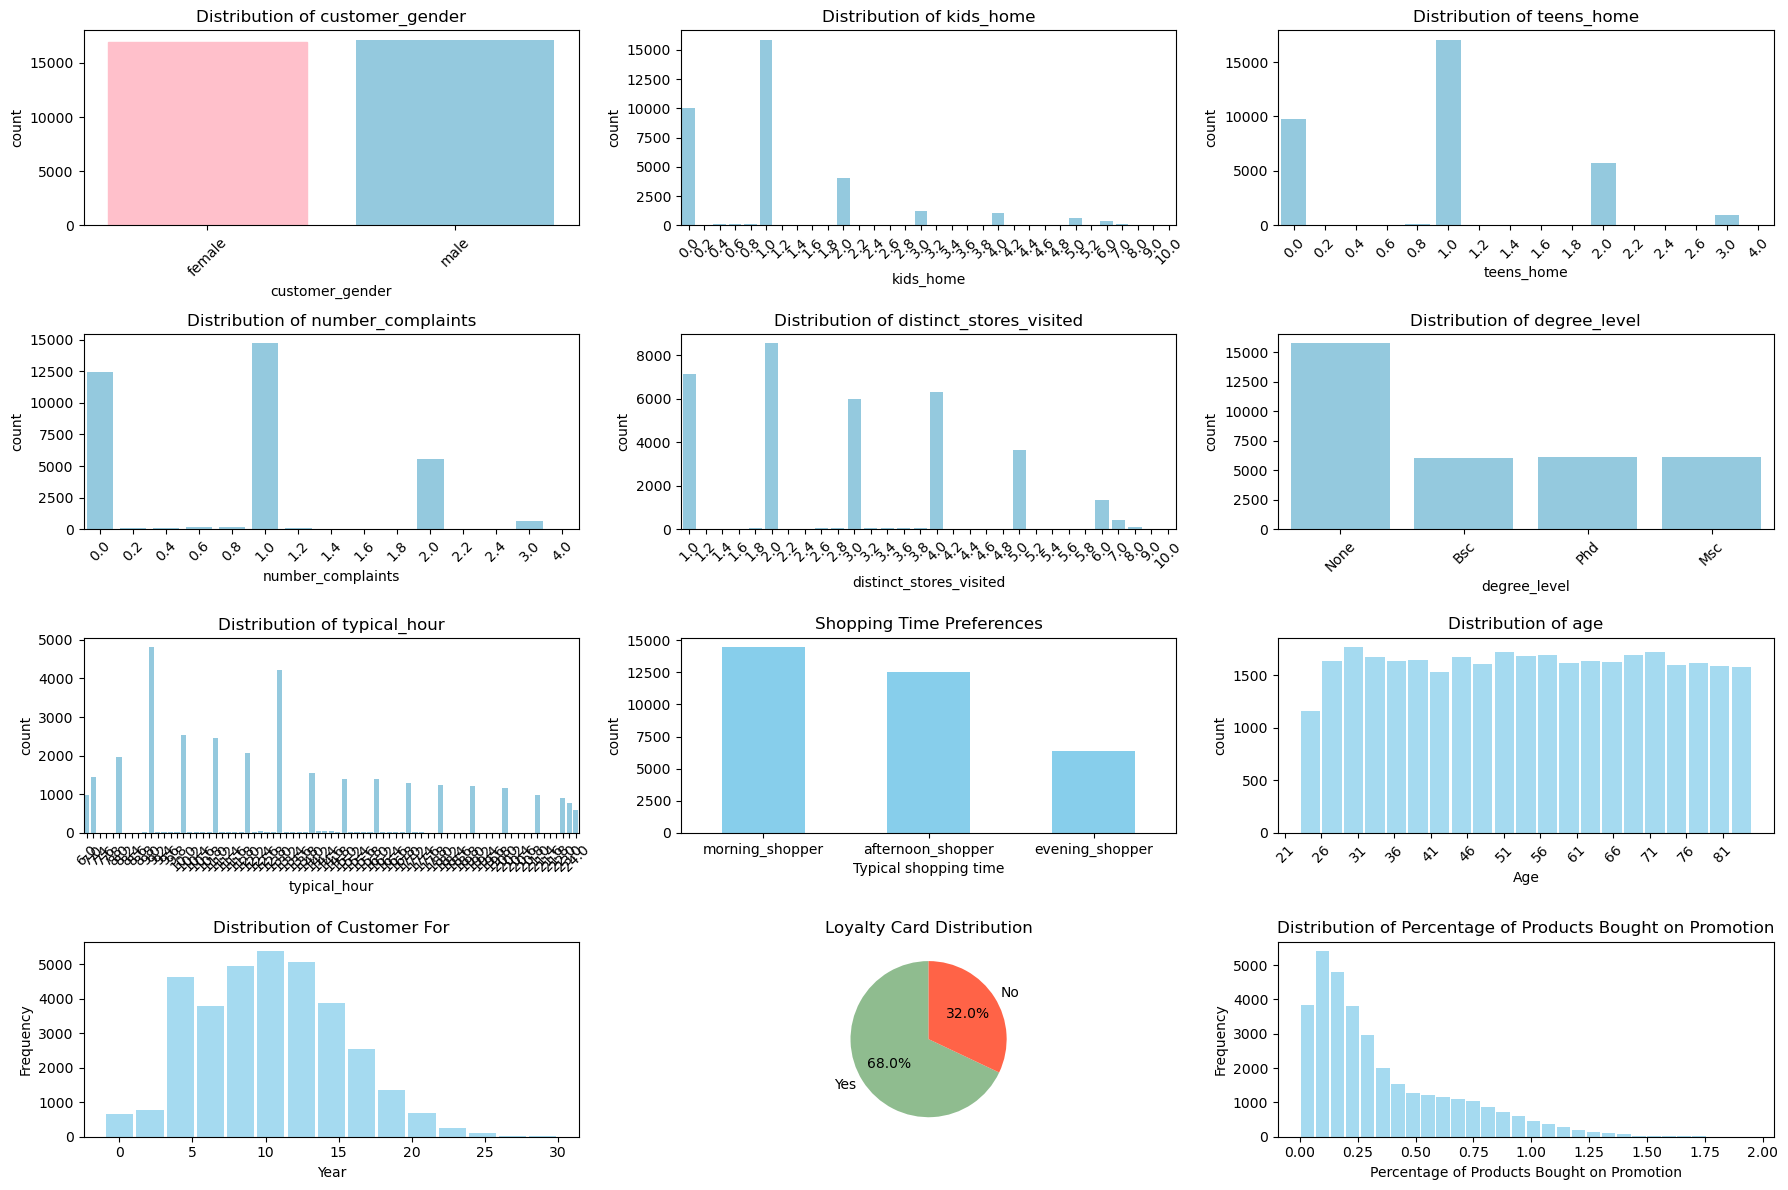

In [911]:
# Define the columns to plot
columns = ['customer_gender', 'kids_home', 'teens_home', 'number_complaints', 
           'distinct_stores_visited', 'degree_level', 'typical_hour'] 

# Create a grid of subplots
fig, axes = plt.subplots(4, 3, figsize=(18, 12))  # Adjust figure size
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Plot general bar plots for each column in the list
for i, col in enumerate(columns):
    sns.countplot(data=info_df, x=col, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Distribution of {col}')
    axes[i].tick_params(axis='x', rotation=45)

# Make female bar of ax 0 to be pink
bars = axes[0].patches  
bars[0].set_color('pink')


# Plot time preferences separately
time_columns = ['morning_shopper', 'afternoon_shopper', 'evening_shopper']
time_preferences = info_df[time_columns].sum()
time_preferences.plot(kind='bar', ax=axes[7], color='skyblue')
axes[7].set_title('Shopping Time Preferences')
axes[7].set_xlabel('Typical shopping time')
axes[7].set_ylabel('count')
axes[7].tick_params(axis='x', rotation=0)

# Plot ages with bins 
sns.histplot(data=info_df, x='age', ax=axes[8], binwidth=3, stat='count', linewidth=0, color='skyblue', element='bars', shrink=0.9)
axes[8].set_title(f'Distribution of age')
axes[8].set_xlabel('Age')
axes[8].set_ylabel('count')
axes[8].tick_params(axis='x', rotation=45)
axes[8].set_xticks(range(21, 86, 5))    # Add x ticks every 5 years

# Plot customer_for 
sns.histplot(data=info_df, x='customer_for', ax=axes[9], bins=15, kde=False, color='skyblue', linewidth=0, shrink=0.9)
axes[9].set_title('Distribution of Customer For')
axes[9].set_xlabel('Year')
axes[9].set_ylabel('Frequency')
axes[9].tick_params(axis='x', rotation=0)

# Plot the pie chart of loyalty card distribution with a frame
loyalty_counts = info_df['loyalty_card'].map({1: 'Yes', 0: 'No'}).value_counts()
loyalty_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, ax=axes[10], colors=['darkseagreen', 'tomato'])
axes[10].set_title('Loyalty Card Distribution')
axes[10].set_ylabel('')

# We have space for one more subplot if we need it  
# fig.delaxes(axes[11])  # Remove the empty subplot

sns.histplot(data=info_df, x='percentage_of_products_bought_promotion', ax=axes[11], color='skyblue', bins=30, linewidth=0, shrink=0.9)
axes[11].set_title('Distribution of Percentage of Products Bought on Promotion')
axes[11].set_xlabel('Percentage of Products Bought on Promotion')
axes[11].set_ylabel('Frequency')


# Adjust layout
plt.tight_layout()
plt.show()

## Customer spending visualization

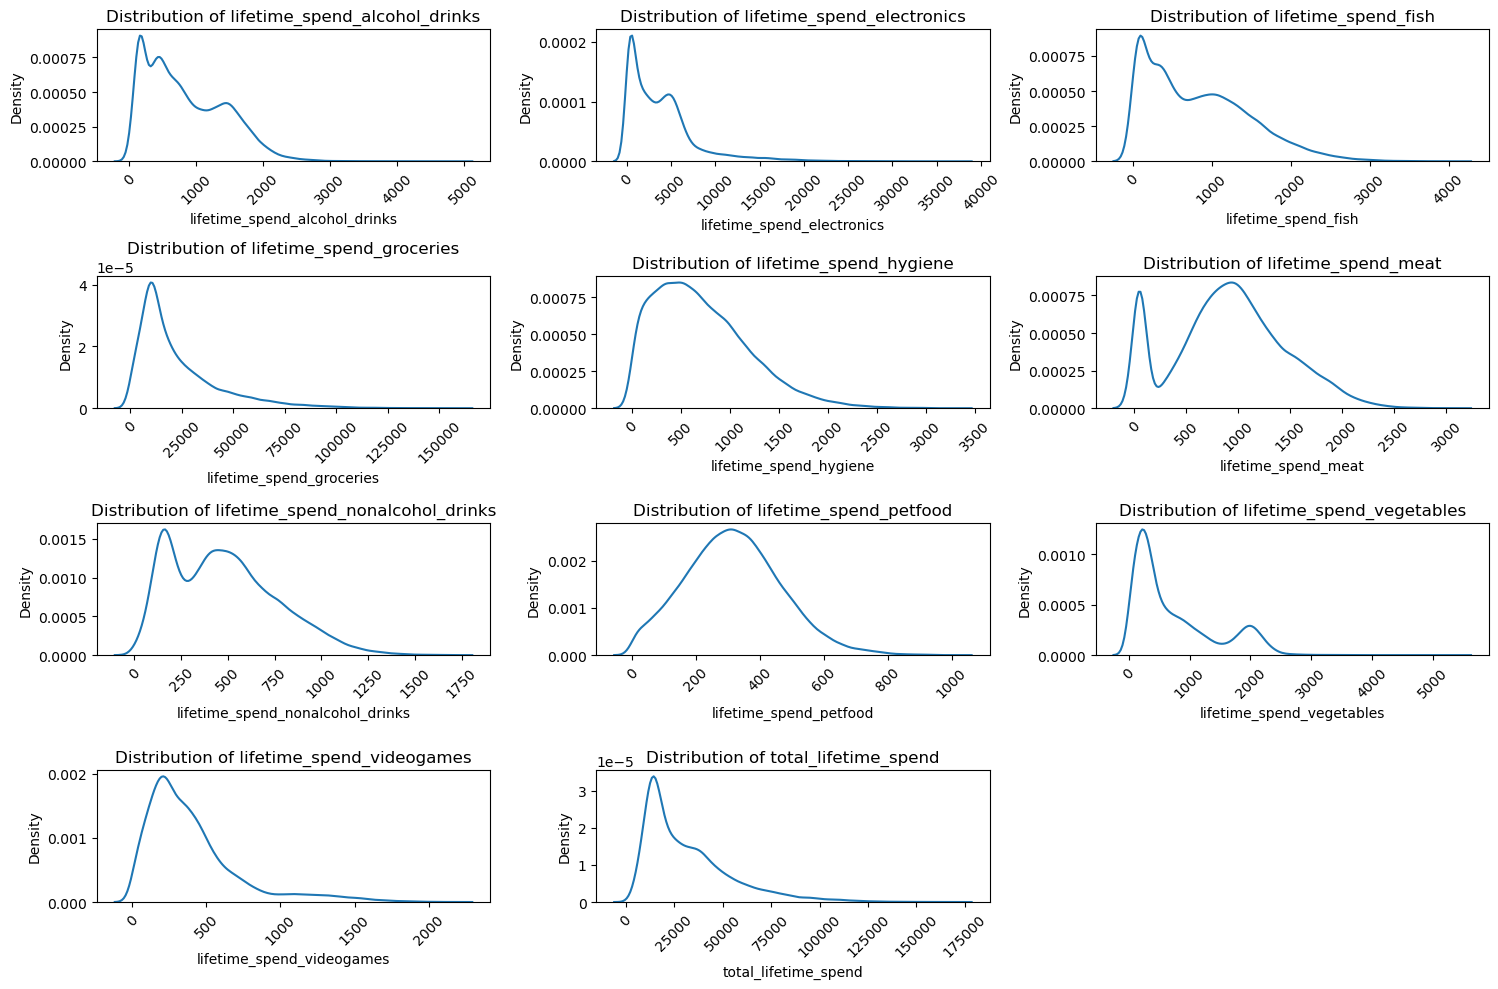

In [912]:
# Get columns with lifetime spend data
spend_columns = [col for col in info_df.columns if 'lifetime_spend' in col]  

# Create a grid of subplots
n_cols = 3  # Set the number of columns in the grid
n_rows = (len(spend_columns) + n_cols - 1) // n_cols  # Calculate the number of rows
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))  
axes = axes.flatten() 

# Plot each column in a subplot
for i, col in enumerate(spend_columns):
    sns.kdeplot(data=info_df, x=col, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].tick_params(axis='x', rotation=45)

# Remove any unused subplots
for j in range(len(spend_columns), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

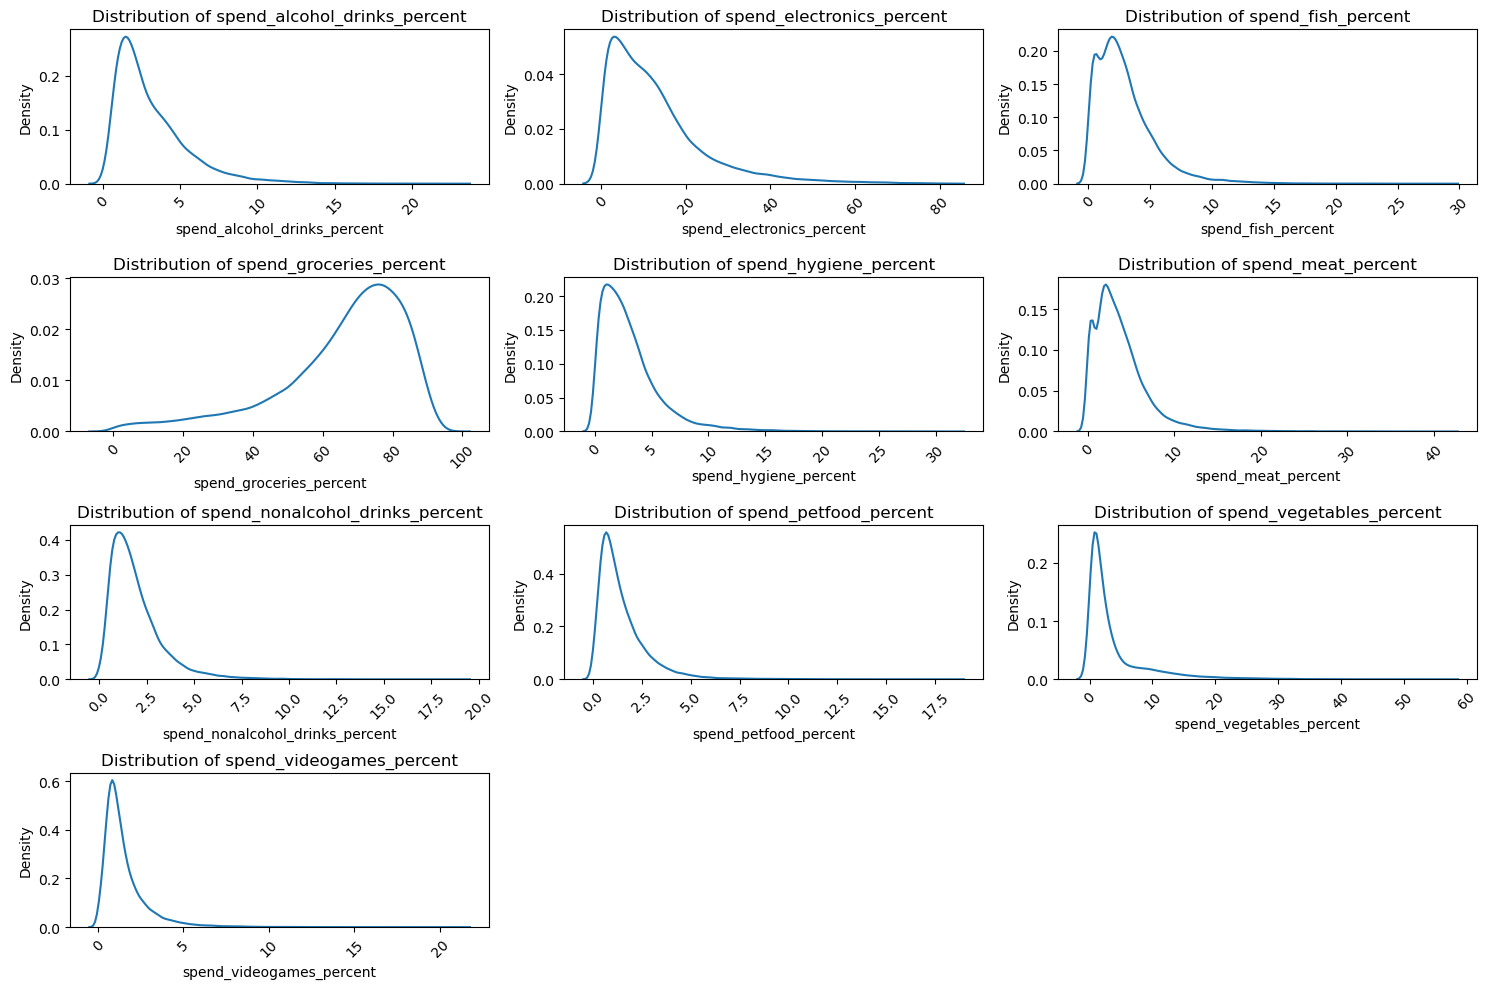

In [913]:
# Get columns with percent spend data for each category
spend_columns = [col for col in info_df.columns if '_percent' in col]

# Create a grid of subplots
n_cols = 3  # Set the number of columns in the grid
n_rows = (len(spend_columns) + n_cols - 1) // n_cols  # Calculate the number of rows
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))  
axes = axes.flatten()  

# Plot each column in a subplot
for i, col in enumerate(spend_columns):
    sns.kdeplot(data=info_df, x=col, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].tick_params(axis='x', rotation=45)

# Remove any unused subplots
for j in range(len(spend_columns), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

## Geographical visualization

In [914]:
fig = px.scatter_mapbox(
    info_df,
    lat='latitude',
    lon='longitude',
    hover_name='customer_name',  # Displays customer_name on hover
    zoom=11,
    height=600,
    width=800
)

# Remove margins and white background
fig.update_layout(
    mapbox_style="open-street-map",
    margin=dict(l=0, r=0, t=0, b=0),  # Removes all margins
    paper_bgcolor='rgba(0,0,0,0)',     # Transparent background
    plot_bgcolor='rgba(0,0,0,0)'       # Transparent plot area
)

fig.show()  # Displays in notebook or browser

## Correlations visualization

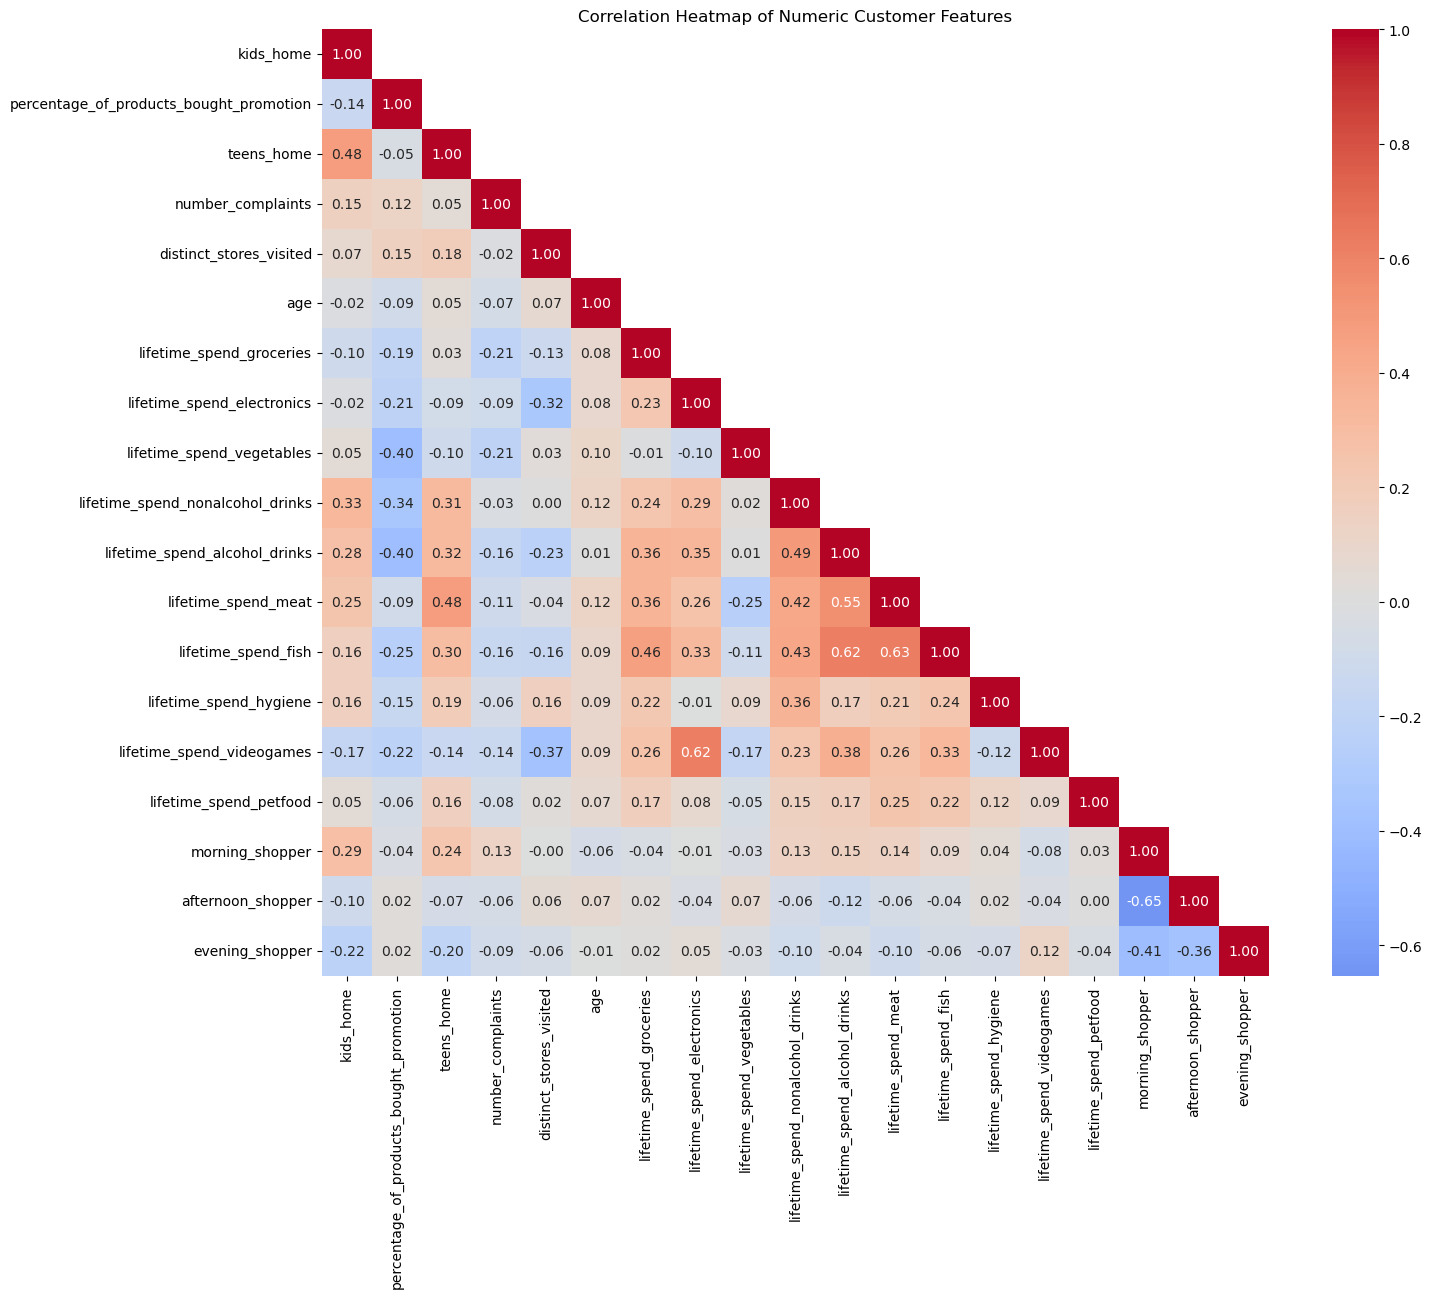

In [915]:
# Define the columns to plot
columns = ['kids_home', 'percentage_of_products_bought_promotion', 'teens_home', 'number_complaints', 
                   'distinct_stores_visited', 'age', 'lifetime_spend_groceries', 'lifetime_spend_electronics', 
                   'lifetime_spend_vegetables', 'lifetime_spend_nonalcohol_drinks', 'lifetime_spend_alcohol_drinks', 
                   'lifetime_spend_meat', 'lifetime_spend_fish', 'lifetime_spend_hygiene', 'lifetime_spend_videogames', 
                   'lifetime_spend_petfood', 'morning_shopper', 'afternoon_shopper', 'evening_shopper']

# Calculate the correlation matrix for the selected columns
correlation_matrix = info_df[columns].corr()

# Create a mask to remove duplicate correlations but keep the diagonal
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

# Plot the heatmap
plt.figure(figsize=(16, 13))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', mask=mask, square=True)
plt.title('Correlation Heatmap of Numeric Customer Features')
plt.tight_layout()
plt.show()

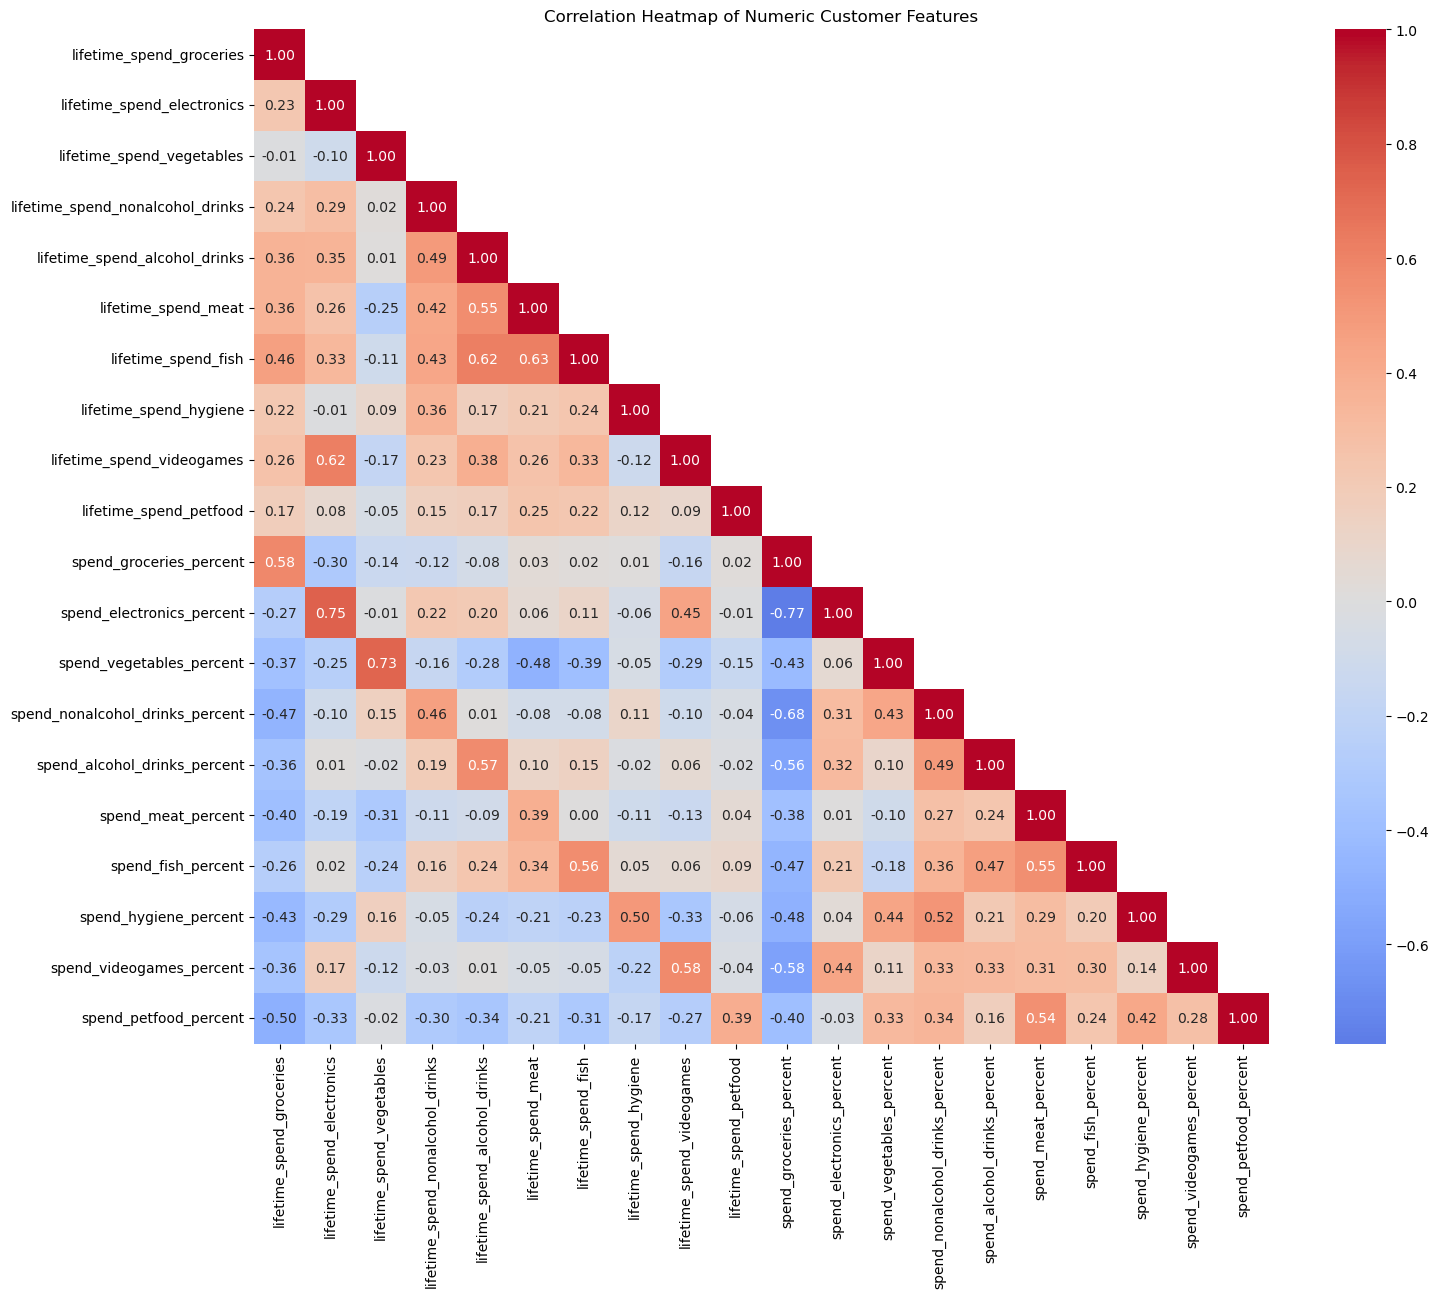

In [916]:
# Cheaking the correlation between lifetime spend and percentage spend
# Define the columns to plot
columns = ['lifetime_spend_groceries',
       'lifetime_spend_electronics', 'lifetime_spend_vegetables',
       'lifetime_spend_nonalcohol_drinks', 'lifetime_spend_alcohol_drinks',
       'lifetime_spend_meat', 'lifetime_spend_fish', 'lifetime_spend_hygiene',
       'lifetime_spend_videogames', 'lifetime_spend_petfood', 
       'spend_groceries_percent',
       'spend_electronics_percent', 'spend_vegetables_percent',
       'spend_nonalcohol_drinks_percent', 'spend_alcohol_drinks_percent',
       'spend_meat_percent', 'spend_fish_percent', 'spend_hygiene_percent',
       'spend_videogames_percent', 'spend_petfood_percent']

# Calculate the correlation matrix for the selected columns
correlation_matrix = info_df[columns].corr()

# Create a mask to remove duplicate correlations but keep the diagonal
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

# Plot the heatmap
plt.figure(figsize=(16, 13))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', mask=mask, square=True)
plt.title('Correlation Heatmap of Numeric Customer Features')
plt.tight_layout()
plt.show()

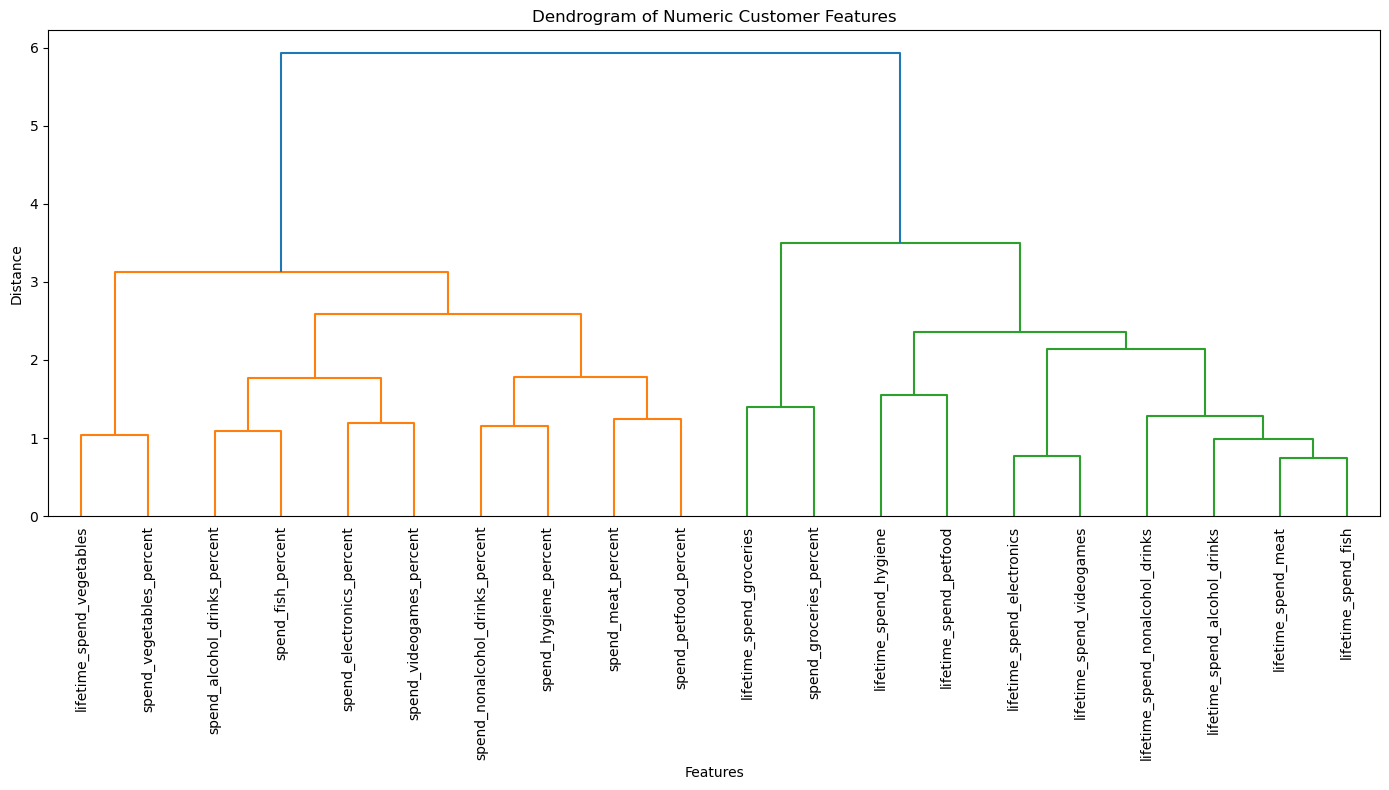

In [917]:
# Convert the correlation matrix to a distance matrix
distance_matrix = 1 - correlation_matrix

# Perform hierarchical clustering
linkage_matrix = sch.linkage(distance_matrix, method='ward')

# Plot the dendrogram
plt.figure(figsize=(14, 8))
dendrogram = sch.dendrogram(linkage_matrix, labels=columns, leaf_rotation=90, leaf_font_size=10)
plt.title('Dendrogram of Numeric Customer Features')
plt.xlabel('Features')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

## Basket visualization

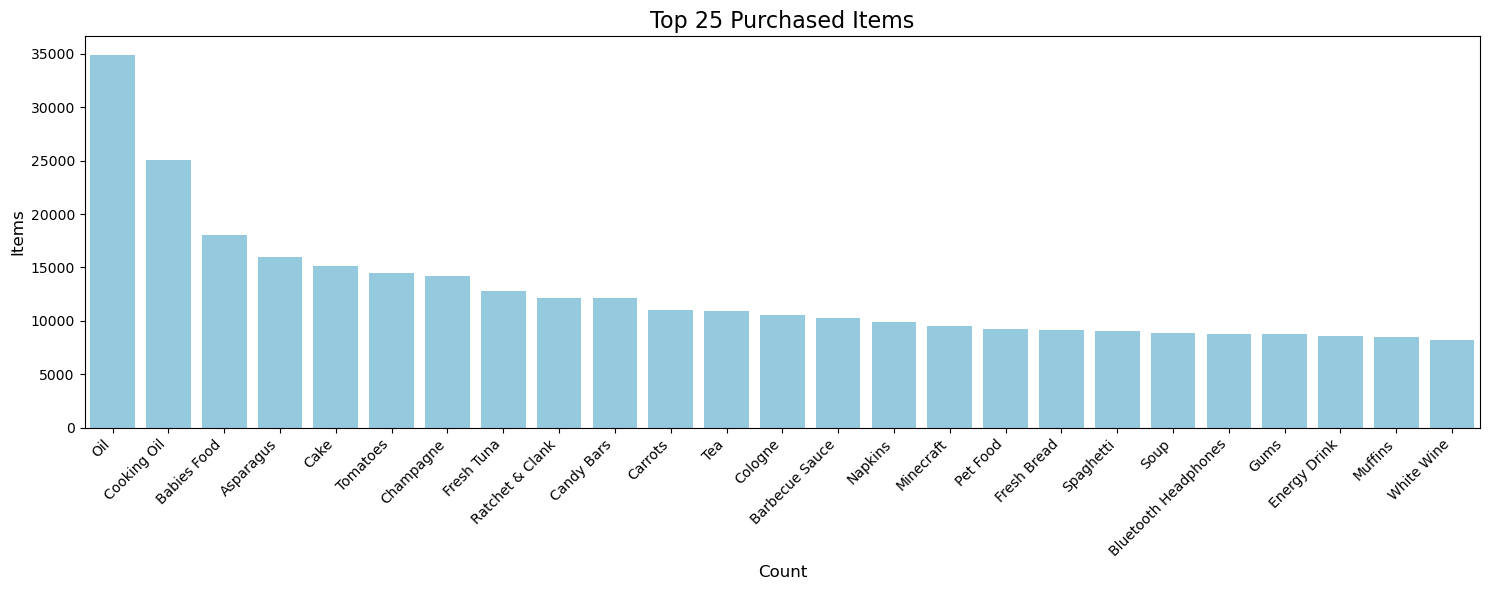

In [918]:
# Count the occurrences of each item
item_counts = Counter([item for sublist in all_items['all_purchased_items'] for item in sublist])

# Get the top most common items
top_items = item_counts.most_common(25)

# Separate the items and their counts for plotting
items, counts = zip(*top_items)
items = [item.replace('_', ' ').title() for item in items]  # Format item names
counts = list(counts)

# Plot the top items
plt.figure(figsize=(15, 6))
sns.barplot(x=items, y=counts, color='skyblue')
plt.title(f'Top {len(items)} Purchased Items', fontsize=16)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Items', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Clustering

## Imputation and Scaling

In [919]:
# Perform some extra preprocessing on info_df, after seeing the visualizations
# Create a new DataFrame with encoded categorical columns and scaled features
# Seperate marko clients
info_df_scaled, marko_clients = extra_preprocessing(info_df)

# Check the shape of the scaled DataFrame
info_df_scaled.shape

(33964, 42)

## DBScan

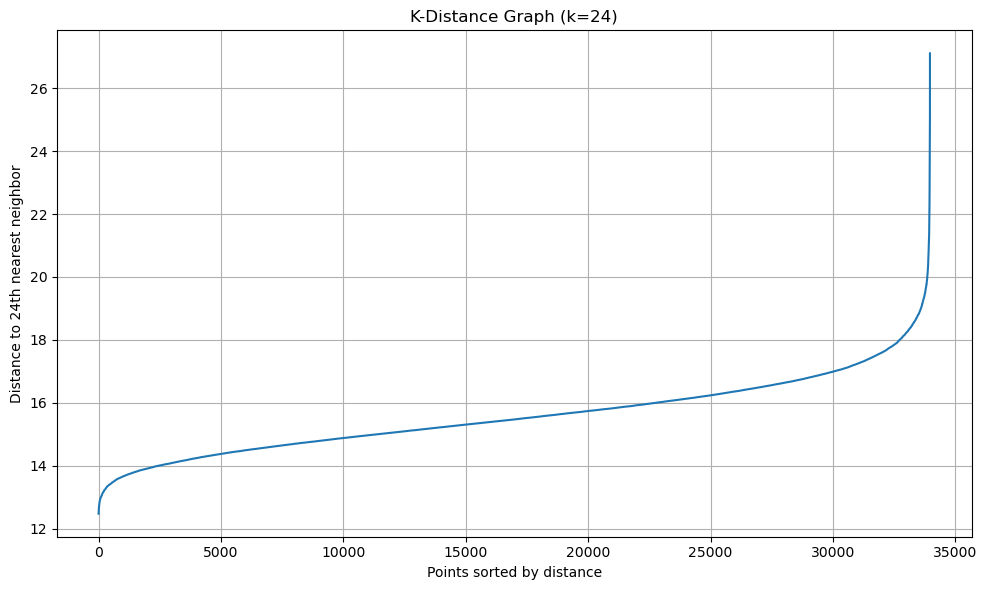

In [920]:
# Plot the k-distance graph to find the DBSCAN epsilon parameter
k_distance_graph(info_df_scaled, k=24)

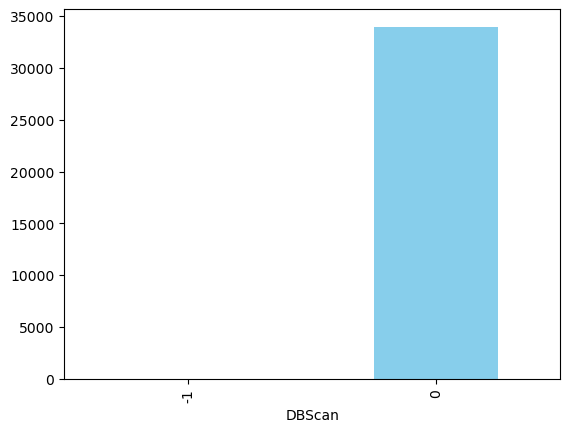

Number of outliers removed: 20


(33944, 42)

In [921]:
# We are going to use a higher value of eps to check for multidimentional outliers
# If there are any, we will them from the main dataset
# For extra safety, we will keep the outliers in a separate DataFrame      
info_df_scaled, outliers_df = remove_outliers(info_df_scaled, 6, 24)

# Check the shape of the scaled DataFrame after removing outliers
info_df_scaled.shape

## Dimensionality reduction with PCA

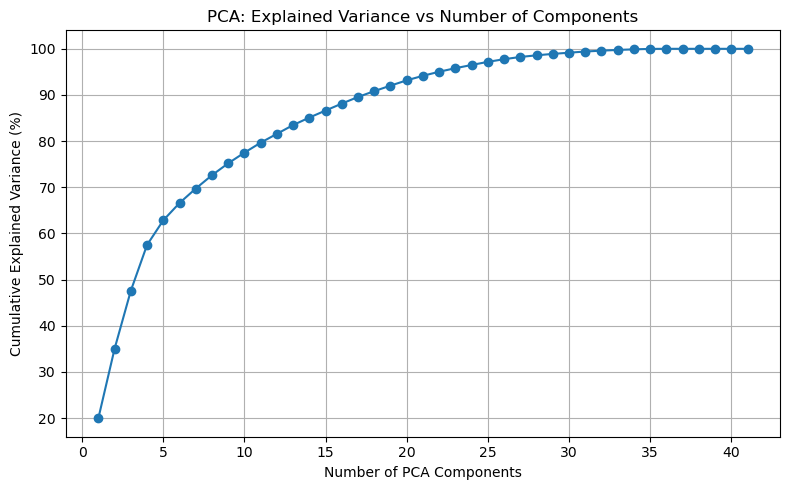

In [922]:
pca_graph(info_df_scaled)

In [923]:
# Reduce the dimensionality of the dataset by applying PCA
info_df_pca = dimensionality_reduction(info_df_scaled, 18)  

Variance explained by each component: [0.19958293 0.15060896 0.1256488  0.09921718 0.05334258 0.03750681
 0.03129614 0.02894088 0.02579298 0.02305931 0.02161198 0.01915102
 0.01904209 0.01621797 0.01524846 0.01502531 0.01435548 0.01265219]
Total variance explained by 18 components: 90.83%


## K-mean

In [924]:
# Plot the inertia and silhouette scores for different values of k
# elbow_and_silhouette(info_df_pca, max_k=20)

In [925]:
# Using the graph above, cluster the data with k-means
k = 6
info_df_clustered = kmeans_clustering(info_df_pca, info_df_scaled, k)

# Mark Marko clients with the cluster number
marko_clients['cluster'] = k

# Combine the clustered DataFrame with the original Marko clients
info_df_clustered = pd.concat([info_df_clustered, marko_clients], axis=0).reset_index(drop=True)

# Cheak the custer profiles
cluster_profiles = generate_cluster_profiles(info_df_clustered)
cluster_profiles

afternoon_shopper   age  customer_for  distinct_stores_visited  \
cluster                                                                   
0                     0.46  0.07          0.05                     0.09   
1                     0.41  0.08          0.23                    -0.08   
2                     0.26  0.10          0.33                     0.11   
3                     0.17 -0.59         -0.38                    -0.42   
4                     0.33  0.06         -0.28                    -0.79   
5                     0.48  0.09         -0.01                     0.50   
6                     0.16  0.04          0.52                    -0.51   

         evening_shopper  kids_home  lifetime_spend_alcohol_drinks  \
cluster                                                              
0                   0.21      -0.01                          -0.32   
1                   0.20      -0.27                           0.37   
2                   0.03       1.99                           0.73   
3                   0.17       0.47                           0.01   
4                   0.34      -0.72                           0.30   
5                   0.22      -0.50                          -0.56   
6                   0.00      -0.98                           2.29   

         lifetime_spend_electronics  lifetime_spend_fish  \
cluster                                                    
0                             -0.22                -0.64   
1                              0.35                 0.54   
2                              0.39                 0.57   
3                             -0.40                -0.20   
4                              1.70                 0.19   
5                             -0.55                -0.40   
6                             -0.65                 1.72   

         lifetime_spend_groceries  ...  teens_home  total_children  \
cluster                            ...                               
0                           -0.26  ...       -0.69           -0.35   
1                            1.43  ...       -0.07           -0.17   
2                            0.04  ...        0.86            1.42   
3                           -0.21  ...       -0.18            0.14   
4                            0.13  ...       -0.71           -0.72   
5                           -0.27  ...       -0.02           -0.26   
6                            1.94  ...       -0.97           -0.98   

         total_lifetime_spend  typical_hour  customer_gender_female  \
cluster                                                               
0                       -0.32          0.13                    0.49   
1                        1.15          0.09                    0.50   
2                        0.12         -0.34                    0.49   
3                       -0.35         -0.17                    0.50   
4                        0.33          0.34                    0.50   
5                       -0.43          0.17                    0.50   
6                        1.54         -0.52                    0.47   

         customer_gender_male  degree_level_Bsc  degree_level_Msc  \
cluster                                                             
0                        0.51              0.21              0.22   
1                        0.50              0.22              0.23   
2                        0.51              0.20              0.20   
3                        0.50              0.06              0.06   
4                        0.50              0.22              0.22   
5                        0.50              0.10              0.10   
6                        0.53              0.00              0.00   

         degree_level_None  degree_level_Phd  
cluster                                       
0                     0.35              0.21  
1                     0.33              0.22  
2                     0.39              0.21  
3                     0.82       

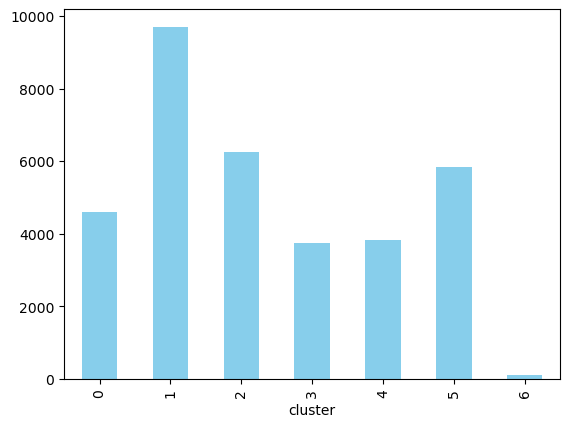

In [926]:
# Cheak the number of customers in each cluster
info_df_clustered.groupby(['cluster']).size().plot(kind='bar', color='skyblue')
plt.show()

In [927]:
# Generate cluster names (most significant features)
cluster_names = generate_cluster_names(cluster_profiles, z_threshold=0.5)

# Print cluster descriptions
for k, v in cluster_names.items():
    print(f"Cluster {k}: {v}\n")

Cluster 0: HIGH : spend vegetables percent, lifetime spend vegetables, spend hygiene percent, spend nonalcohol drinks percent | LOW : lifetime spend meat, spend meat percent, teens home, spend fish percent

Cluster 1: HIGH : lifetime spend groceries, total lifetime spend, lifetime spend fish, lifetime spend hygiene | LOW : number complaints, spend petfood percent, kids home, spend nonalcohol drinks percent

Cluster 2: HIGH : kids home, total children, spend alcohol drinks percent, spend fish percent | LOW : spend groceries percent, typical hour, loyalty card

Cluster 3: HIGH : spend alcohol drinks percent, degree level None, percentage of products bought promotion, number complaints | LOW : age, loyalty card, lifetime spend meat, lifetime spend videogames

Cluster 4: HIGH : lifetime spend videogames, spend videogames percent, spend electronics percent, lifetime spend electronics | LOW : spend groceries percent, distinct stores visited, kids home, total children

Cluster 5: HIGH : spend

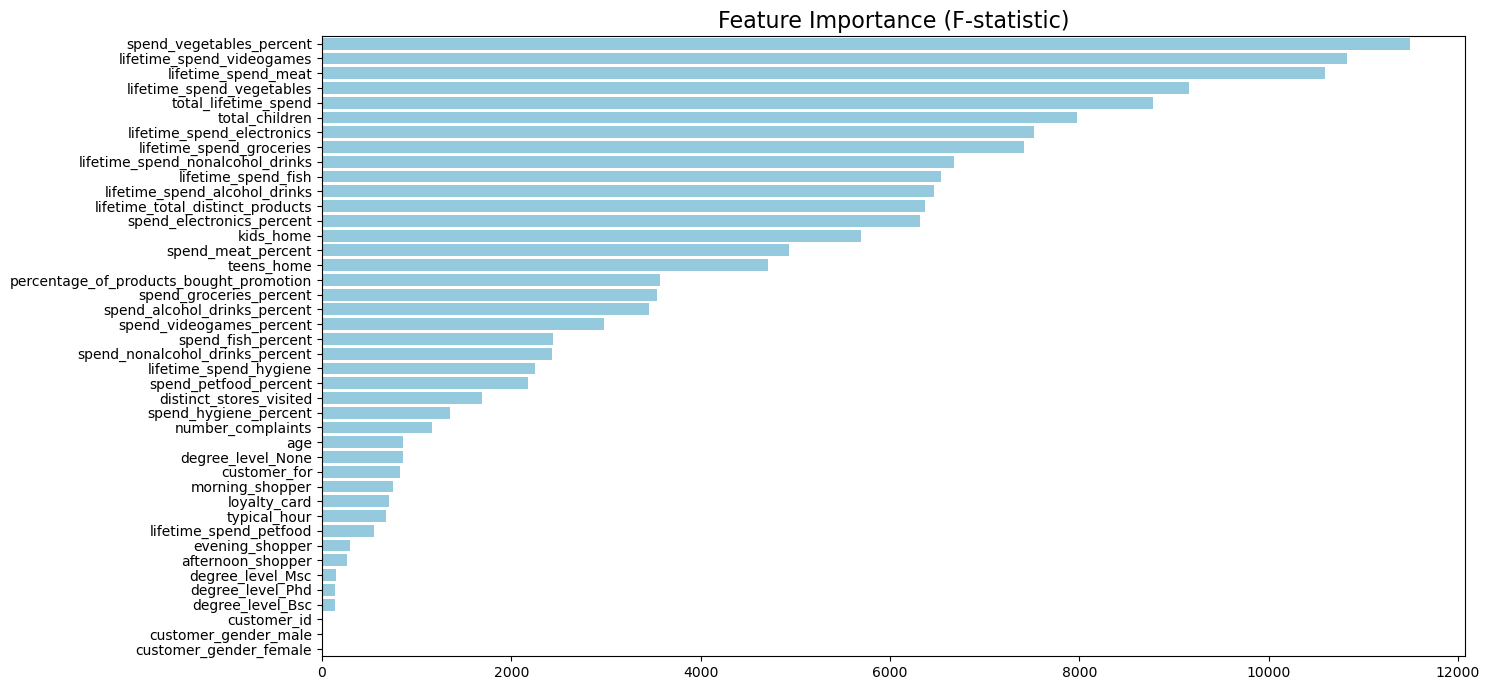

In [928]:
# Calculate and plot feature importance based on F-statistic
calculate_f_statistic_importance(info_df_clustered)

## UMAP

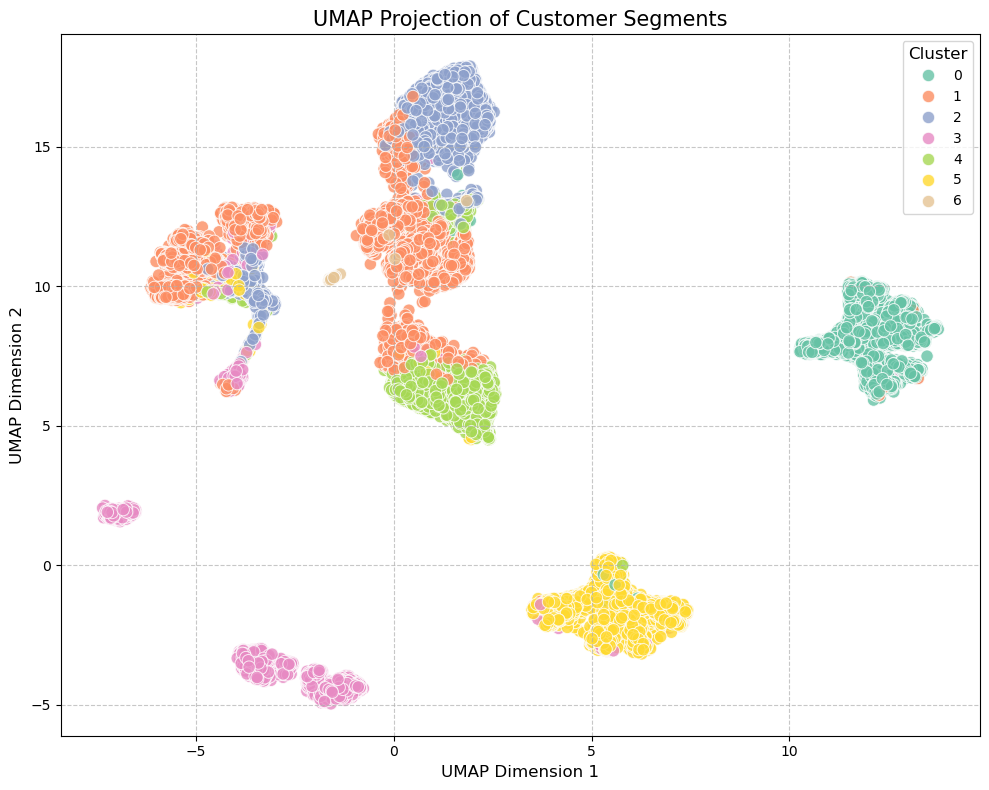

In [929]:
# Set a random seed for reproducibility
random_state = 42

# Apply UMAP for dimensionality reduction
umap_model = UMAP(n_components=2, random_state=random_state)
umap_result = umap_model.fit_transform(info_df_clustered.drop(columns=['cluster', 'customer_id'] , axis=1))

# Create the visualization
plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(
    x=umap_result[:, 0], 
    y=umap_result[:, 1], 
    hue=info_df_clustered['cluster'], 
    palette='Set2',
    alpha=0.8,
    s=80
)

# Add title and labels
plt.title('UMAP Projection of Customer Segments', fontsize=15)
plt.xlabel('UMAP Dimension 1', fontsize=12)
plt.ylabel('UMAP Dimension 2', fontsize=12)

# Improve legend
plt.legend(title='Cluster', title_fontsize=12, fontsize=10)

# Add a grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Tight layout
plt.tight_layout()
 
# Show the plot
plt.show()

In [930]:
# Apply UMAP for 3D dimensionality reduction
umap_model_3d = UMAP(n_components=3, random_state=random_state)
umap_result_3d = umap_model_3d.fit_transform(info_df_clustered.drop(columns=['cluster', 'customer_id'], axis=1))

# Create a 3D scatter plot with Plotly and set a square aspect ratio
fig = px.scatter_3d(
    x=umap_result_3d[:, 0],
    y=umap_result_3d[:, 1],
    z=umap_result_3d[:, 2],
    color=info_df_clustered['cluster'].astype(str),
    title='3D UMAP Projection of Customer Segments',
    labels={'color': 'Cluster'},
    opacity=1
)
fig.update_traces(marker=dict(size=4))
fig.update_layout(
    scene=dict(
        aspectmode='cube'  # Makes the plot more square
    ),
    width=700,
    height=700
)
fig.show()


## PCA

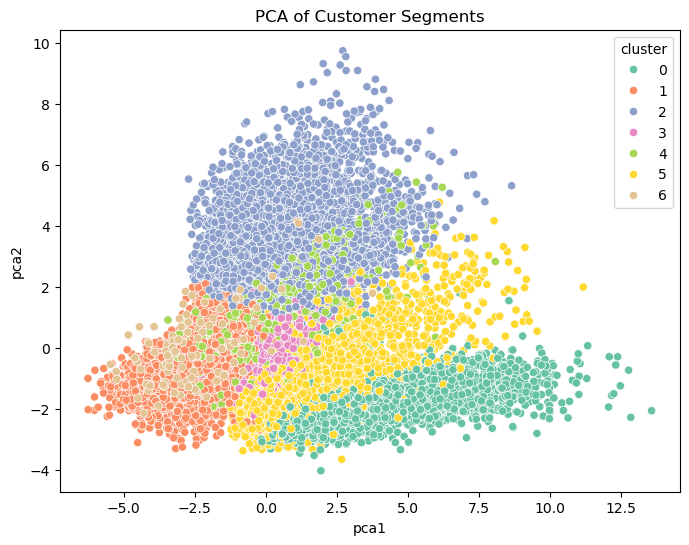

Variance explained by each component: [0.19945117 0.14996662]
Total variance explained: 34.94%


In [931]:

pca = PCA(n_components=2)
pca_result = pca.fit_transform(info_df_clustered.drop(columns=['cluster', 'customer_id'], axis=1))
info_df_clustered['pca1'] = pca_result[:, 0]
info_df_clustered['pca2'] = pca_result[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=info_df_clustered, x='pca1', y='pca2', hue='cluster', palette='Set2')
plt.title('PCA of Customer Segments')
plt.show()

# Get explained variance ratio
explained_variance = pca.explained_variance_ratio_
print(f"Variance explained by each component: {explained_variance}")
print(f"Total variance explained: {sum(explained_variance):.2%}")

## Cluster summary

In [932]:
info_df_clustered.head()

customer_id  afternoon_shopper       age  customer_for  \
0        29930                1.0 -0.032258     -0.428571   
1         6813                1.0  0.870968      0.285714   
2        39451                1.0 -0.580645      0.571429   
3        21557                1.0 -0.161290      0.857143   
4        16415                1.0  0.161290      0.428571   

   distinct_stores_visited  evening_shopper  kids_home  \
0                      0.5              0.0        1.0   
1                      0.5              0.0       -1.0   
2                      2.0              0.0        1.0   
3                     -1.0              0.0       -1.0   
4                      1.0              0.0        0.0   

   lifetime_spend_alcohol_drinks  lifetime_spend_electronics  \
0                       0.534810                    0.594066   
1                      -0.635021                   -0.657002   
2                       1.229958                    0.296022   
3                       1.212025                    3.013711   
4                      -0.167722                    0.053720   

   lifetime_spend_fish  ...  typical_hour  customer_gender_female  \
0             1.186818  ...      0.000000                     1.0   
1            -0.378083  ...      0.142857                     0.0   
2             1.264658  ...      0.142857                     1.0   
3             0.065710  ...      0.142857                     0.0   
4             0.780429  ...      0.142857                     0.0   

   customer_gender_male  degree_level_Bsc  degree_level_Msc  \
0                   0.0               0.0               0.0   
1                   1.0               1.0               0.0   
2                   0.0               0.0               0.0   
3                   1.0               0.0               0.0   
4                   1.0               0.0               0.0   

   degree_level_None  degree_level_Phd  cluster      pca1      pca2  
0                1.0               0.0        2  1.057825  3.999673  
1                0.0               0.0        5  1.236134 -2.369992  
2                1.0               0.0        2  0.465244  3.027681  
3                1.0               0.0        4 -1.191802  0.451719  
4                0.0               1.0        1 -2.426378 -0.809816  

[5 rows x 45 columns]

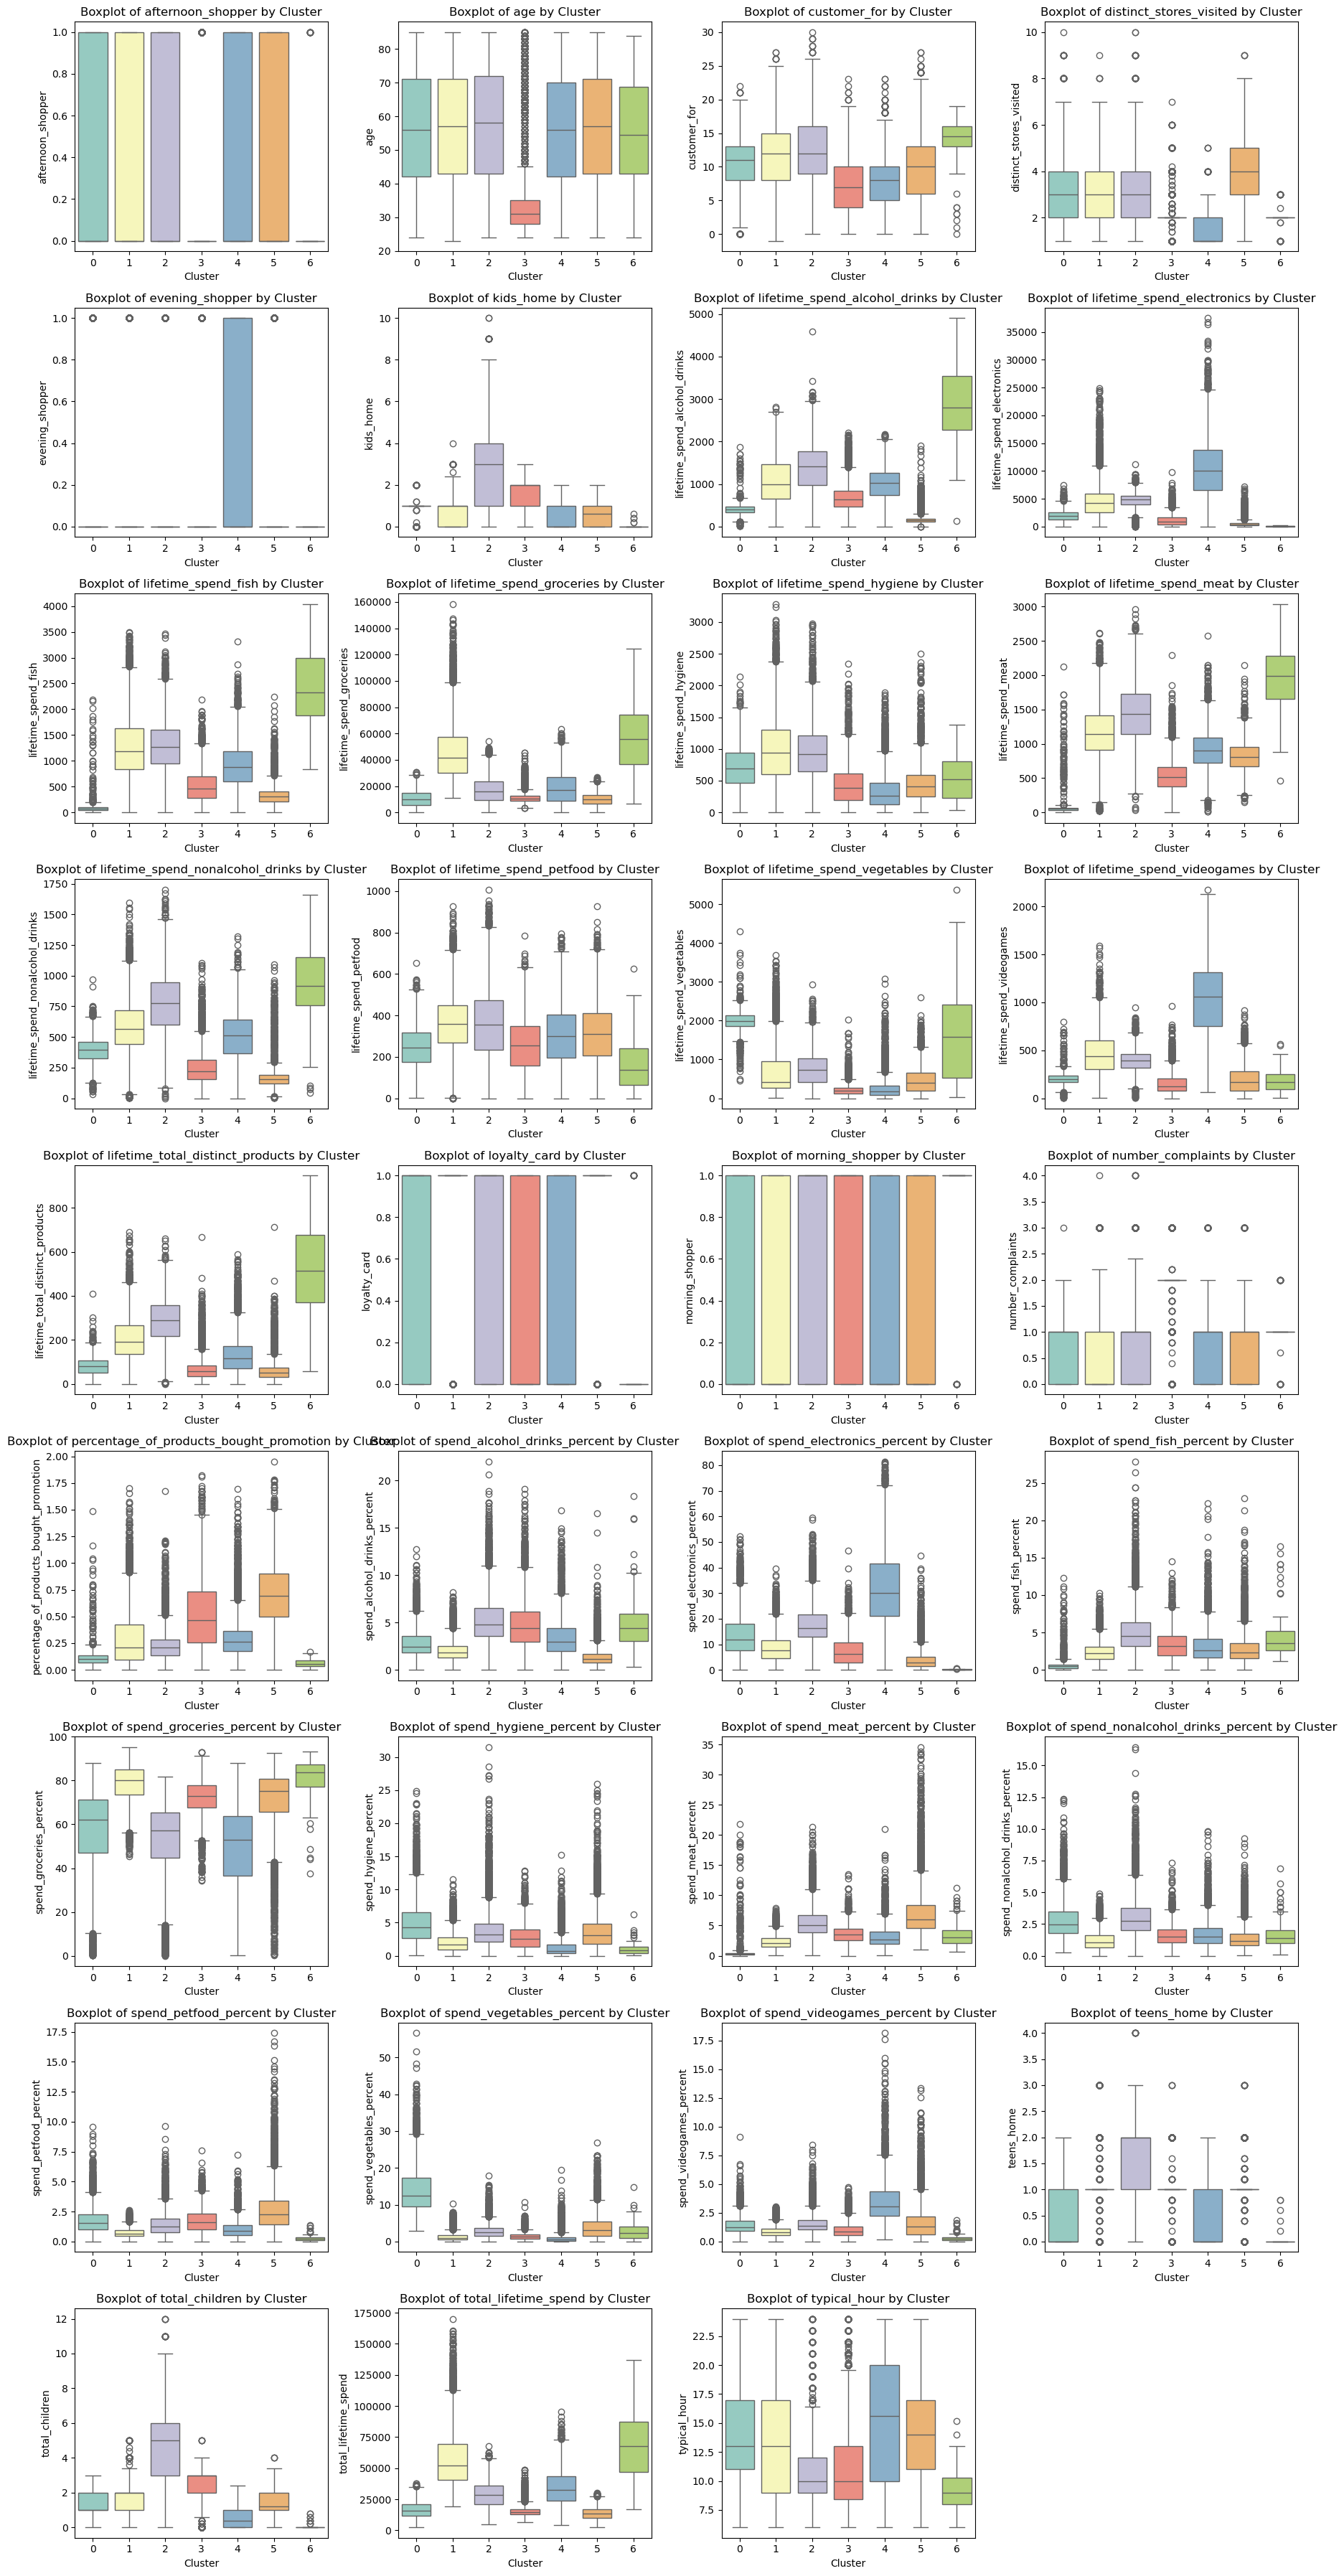

In [933]:
# Merge the cluster labels from info_df_clustered into info_df using customer_id
info_df_with_cluster = info_df.merge(
    info_df_clustered[['customer_id', 'cluster']],
    on='customer_id',
    how='right'
)

# Select numeric columns (excluding customer_id and cluster)
numeric_cols = info_df_with_cluster.select_dtypes(include=[np.number]).columns.difference(['customer_id', 'cluster'])

# Plot boxplots for each numeric variable grouped by cluster
n_cols = 4
n_rows = int(np.ceil(len(numeric_cols) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.boxplot(
        data=info_df_with_cluster,
        x='cluster',
        y=col,
        ax=axes[i],
        palette='Set3'
    )
    axes[i].set_title(f'Boxplot of {col} by Cluster')
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel(col)

# Remove unused subplots
for j in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Association Rules

In [934]:
# Run the analysis
merged_df, results = get_association_rules_by_cluster(basket_df, info_df_clustered)

In [935]:
# Print nice formatted results
print_recommendations(results, cluster_names)


ASSOCIATION RULES RECOMMENDATIONS BY CLUSTER

🔹 CLUSTER 0
   HIGH : spend vegetables percent, lifetime spend vegetables, spend hygiene percent, spend nonalcohol drinks percent | LOW : lifetime spend meat, spend meat percent, teens home, spend fish percent
   Total transactions: 13643
   Top recommendations:
   1. If customer buys 'deodorant'
      → 13% likely to also buy 'cologne'
      → 1.3x more likely than average

   2. If customer buys 'mint'
      → 11% likely to also buy 'hot dogs'
      → 1.3x more likely than average

   3. If customer buys 'flax seed'
      → 10% likely to also buy 'salad'
      → 1.3x more likely than average

   4. If customer buys 'salad'
      → 17% likely to also buy 'flax seed'
      → 1.3x more likely than average


🔹 CLUSTER 1
   HIGH : lifetime spend groceries, total lifetime spend, lifetime spend fish, lifetime spend hygiene | LOW : number complaints, spend petfood percent, kids home, spend nonalcohol drinks percent
   Total transactions: 28184
 